In [29]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [30]:
transform = transforms.ToTensor()
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

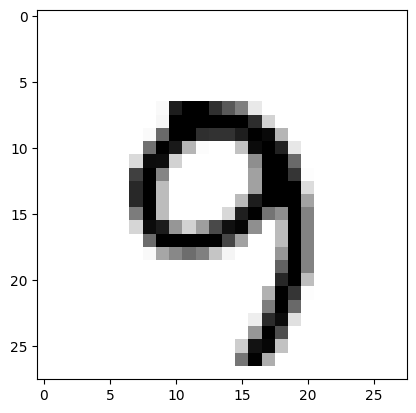

In [31]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [32]:
print(imagens[0].shape)     #para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape)   #para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [33]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64)    #camada de interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10)     #camada de interna 2, 64 neurônios que se ligam a 10
    #para a camada de saída não é necessário definir nada, pois só precisamos pegar o output da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X))          #função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X))          #função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X)                  #função de ativação da camada interna 2 para a camada de saída, neste caso f(x) = x
    return F.log_softmax(X, dim=1)       #dados utilizados para calcular a perda

In [34]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a política de atualização dos pesos e da bias
  inicio = time()                                                    #timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss()                                            #definindo o critério para calcular a perda
  EPOCHS = 10                                                        #número de épocas (epochs) que o algoritmo rodará
  modelo.train()                                                     #ativando o modo de trinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0                                              #variável para acumular a perda em cada época

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1)                   #redimensionando o tensor das imagens
      otimizador.zero_grad()                                         #zerando os gradientes

      output = modelo(imagens.to(device))                            #colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device))     #calculando a perda da epoch em questão

      perda_instantanea.backward()                                   #backpropagation a partir da perda
      otimizador.step()                                              #atualizando os pesos e bias
      perda_acumulada += perda_instantanea.item()                    #atualização da perda acumulada

    else:
      print("Época {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [35]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #desativar o autograd para acelerar a validaão. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device))            #output do modelo em escala logarítmica


      ps = torch.exp(logps)                       #converte output para escala normal (lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))   #maior probabilidade é a predição do modelo
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):        #compara a previsão com valor correto
        conta_corretas += 1
      contas_todas += 1

  print("Total de imagens testadas =", contas_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/contas_todas))

In [36]:
modelo = Modelo() #inicializa o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #modelo rodará na GPU se possível
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)